In [1]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

In [2]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

(512, 512)
int16


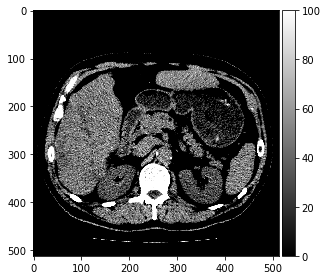

In [7]:
io.imshow(img, vmin=0, vmax=100, cmap='gray')
io.show()

In [11]:
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]
mu_spleen = np.mean(spleen_values)
std_spleen = np.std(spleen_values)
print(np.mean(spleen_values))
print(np.std(spleen_values))

49.48026905829597
14.9970794143059


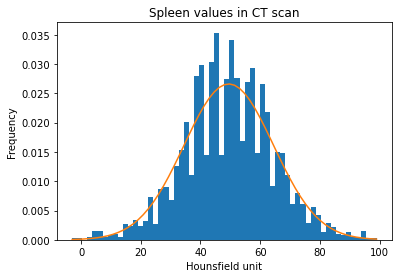

In [12]:
n, bins, patches = plt.hist(spleen_values, 60, density=1)
pdf_spleen = norm.pdf(bins, mu_spleen, std_spleen)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

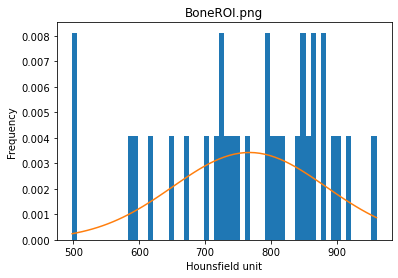

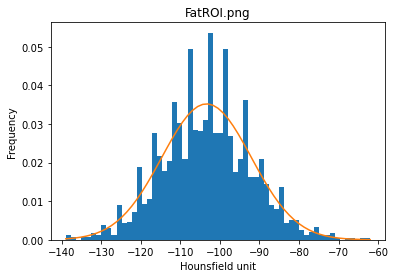

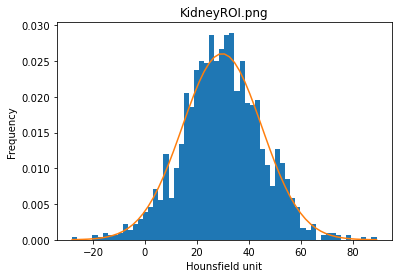

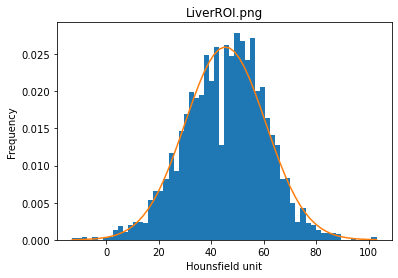

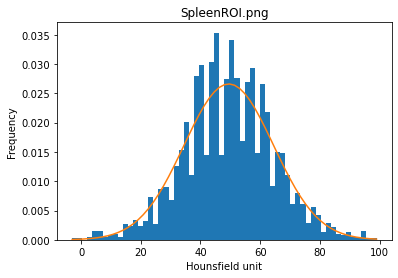

In [14]:
def load_mask(mask_path):
    roi = io.imread(mask_path)
    mask = roi > 0
    return mask
def get_values(img, mask_path):
    mask = load_mask(mask_path)
    return img[mask]

paths = ['BoneROI.png', 'FatROI.png', 'KidneyROI.png','LiverROI.png','SpleenROI.png']
values = [get_values(img, in_dir + path) for path in paths]

def get_gaussian_distributions(values, min_hu = -200, max_hu = 1000):
    hu_range = np.arange(min_hu, max_hu, 1.0)
    mu = np.mean(values)
    std = np.std(values)
    pdf = norm.pdf(hu_range, mu, std)
    return pdf

for value, name in zip(values, paths):
    n, bins, patches = plt.hist(value, 60, density=1)
    mu = np.mean(value)
    std = np.std(value)
    pdf = norm.pdf(bins, mu, std)
    plt.plot(bins, pdf)
    plt.xlabel('Hounsfield unit')
    plt.ylabel('Frequency')
    plt.title(name)
    plt.show()

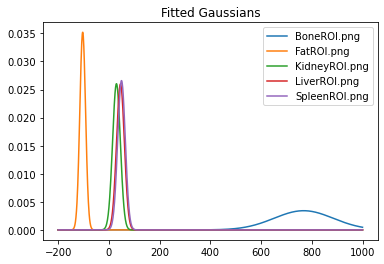

In [15]:
# Hounsfield unit limits of the plot
min_hu, max_hu = -200, 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdfs = [get_gaussian_distributions(value) for value in values]

for pdf, path in zip(pdfs, paths):
    plt.plot(hu_range, pdf, label=path)
    
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

In [25]:
val_soft = np.concatenate(values[-3:])
val_mean = np.mean(val_soft)
bone_mean = np.mean(values[0])
fat_mean = np.mean(values[1])
print(f'Soft tissue mean: {val_mean}, bone mean: {bone_mean}, fat_mean: {fat_mean}')

Soft tissue mean: 43.00880789673501, bone mean: 766.9375, fat_mean: -103.39037725533078


In [28]:
t_fat_soft = (val_mean + fat_mean)/2
t_soft_bone = (val_mean + bone_mean)/2
t_background = -200
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img < t_soft_bone)
bone_img = (img > t_soft_bone) & (img < 1000)

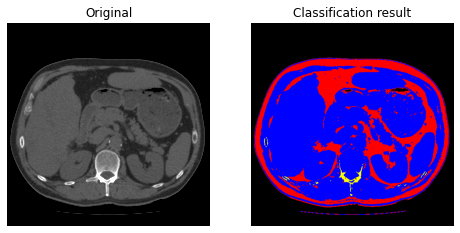

In [29]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

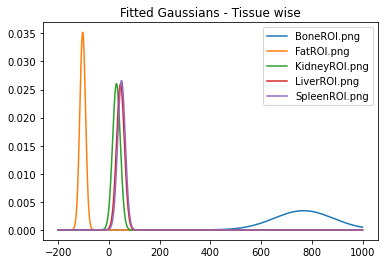

In [30]:
min_hu, max_hu = -200, 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdfs = [get_gaussian_distributions(value) for value in values]

for pdf, path in zip(pdfs, paths):
    plt.plot(hu_range, pdf, label=path)
    
plt.title("Fitted Gaussians - Tissue wise")
plt.legend()
plt.show()

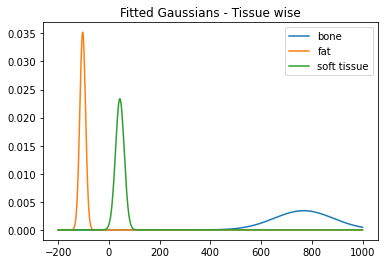

In [32]:
min_hu, max_hu = -200, 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
nuvalues = [values[0], values[1], val_soft]
pdfs = [get_gaussian_distributions(value) for value in nuvalues]
labels = ['bone', 'fat', 'soft tissue']

for pdf, path in zip(pdfs, labels):
    plt.plot(hu_range, pdf, label=path)
    
plt.title("Fitted Gaussians - Tissue wise")
plt.legend()
plt.show()

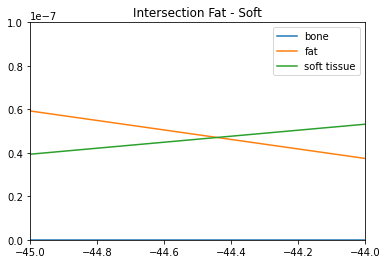

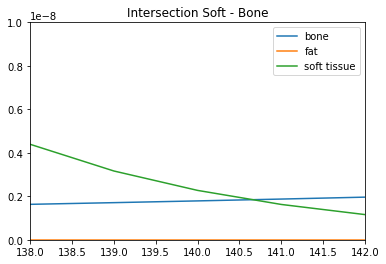

In [36]:
# Manual intersection Fat - Soft
for pdf, path in zip(pdfs, labels):
    plt.plot(hu_range, pdf, label=path)
plt.title("Intersection Fat - Soft")
plt.xlim(-45, -44)
plt.ylim(0, 1e-7)
plt.legend()
plt.show()

# Manual intersection  Soft - Bone
for pdf, path in zip(pdfs, labels):
    plt.plot(hu_range, pdf, label=path)
    
plt.title("Intersection Soft - Bone")
plt.xlim(138, 142)
plt.ylim(0, 1e-8)
plt.legend()
plt.show()

In [37]:
fat_img = (img > t_background) & (img <= -25)
soft_img = (img > -45) & (img < 140)
bone_img = (img > 140) & (img < 1000)

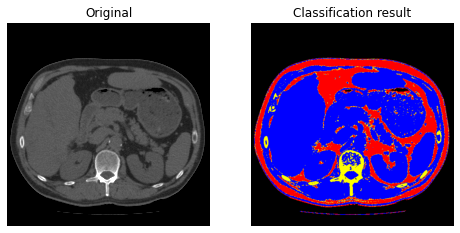

In [38]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

In [39]:
# Automatic intersection Fat - Soft
std_soft = np.std(val_soft)
std_bone = np.std(values[0])
std_fat = np.std(values[1])

for test_value in np.linspace(fat_mean, val_mean, 1000):
    if norm.pdf(test_value, val_mean, std_soft) > norm.pdf(test_value, fat_mean, std_fat):
        thres_fat_soft = test_value
        print(f"Fat - Soft threshold: {thres_fat_soft}")
        break

# Automatic intersection Soft - Bone
for test_value in np.linspace(val_mean, bone_mean, 1000):
    if norm.pdf(test_value, bone_mean, std_bone) > norm.pdf(test_value, val_mean, std_soft):
        thres_soft_bone = test_value
        print(f"Soft - Bone threshold: {thres_soft_bone}")
        break

Fat - Soft threshold: -44.332447709502425
Soft - Bone threshold: 140.83700953231136


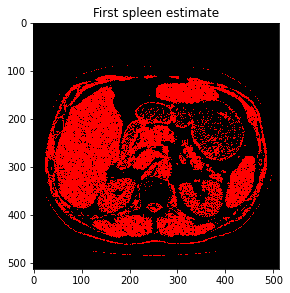

In [40]:
t_1 = 20
t_2 = 80
spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

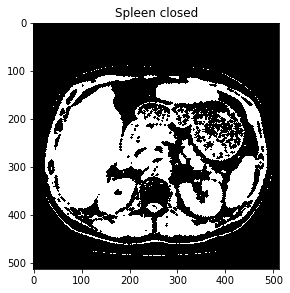

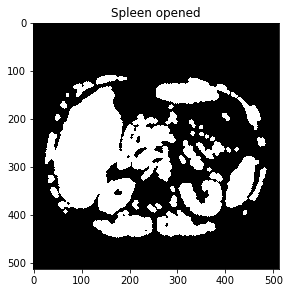

In [52]:
footprint = disk(2)
closed = binary_closing(spleen_estimate, footprint)
io.imshow(closed)
plt.title('Spleen closed')
io.show()

footprint = disk(4)
opened = binary_opening(closed, footprint)
io.imshow(opened)
plt.title('Spleen opened')
io.show()

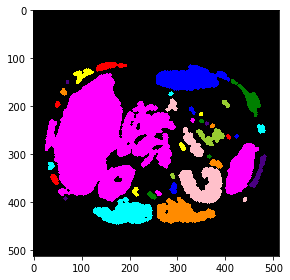

In [53]:
label_img = measure.label(opened)
im_blob = label2rgb(label_img)
io.imshow(im_blob)
io.show()

In [54]:
region_props = measure.regionprops(label_img)

areas = np.array([prop.area for prop in region_props])
print(areas)
perimeters = np.array([prop.perimeter for prop in region_props])
print(perimeters)

[  738  5443   654 39829  1387    49   146    74   387   169   130   164
    60    91    78    58    79   251  1218  1094    85    60   189  4513
    64   764   336   183  4431    93   281   262   195   134   209    49
  4054  4431    71]
[ 167.2670273   437.7300141   146.99494937 2219.89480324  243.70562748
   24.97056275   46.52691193   31.21320344   98.12489168   52.76955262
   43.69848481   53.35533906   27.79898987   34.627417     31.79898987
   26.97056275   31.79898987   65.59797975  194.59292911  214.39191899
   34.04163056   27.79898987   56.18376618  321.30360723   28.38477631
  183.37972568   80.81118318   54.76955262  417.28636329   36.04163056
   69.254834     67.84062043   58.18376618   44.52691193   58.42640687
   24.97056275  404.21529548  396.55844123   30.627417  ]


In [59]:
print(perimeters[(areas < 10000) & (areas > 2000)])

[437.7300141  321.30360723 417.28636329 404.21529548 396.55844123]


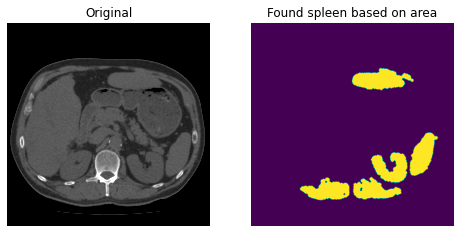

In [66]:
min_area = 2000
max_area = 10000
min_perim = 300
max_perim = 340

# Create a copy of the label_img
label_img_filter = label_img.copy()
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area')

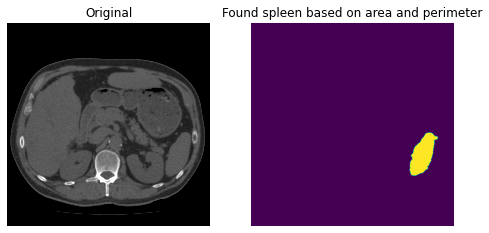

In [68]:
label_img_filter = label_img.copy()
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area or region.perimeter > max_perim or region.perimeter < min_perim:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area and perimeter')

In [75]:
def spleen_finder(img):
    t_1, t_2 = 20, 80
    spleen_estimate = (img > t_1) & (img < t_2)
    footprint = disk(2)
    closed = binary_closing(spleen_estimate, footprint)
    footprint = disk(4)
    opened = binary_opening(closed, footprint)
    label_img = measure.label(opened)
    region_props = measure.regionprops(label_img)
    min_area = 2000
    max_area = 10000
    min_perim = 100
    max_perim = 350
    label_img_filter = label_img.copy()
    for region in region_props:
        crit1 = region.area > max_area or region.area < min_area
        crit2 = region.perimeter > max_perim or region.perimeter < min_perim
        if crit1 or crit2:
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
    i_area = label_img_filter > 0
    return i_area

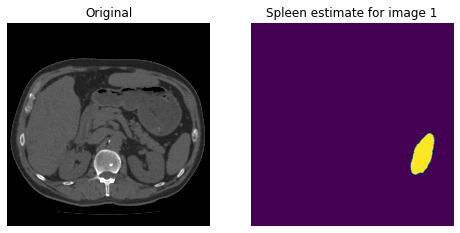

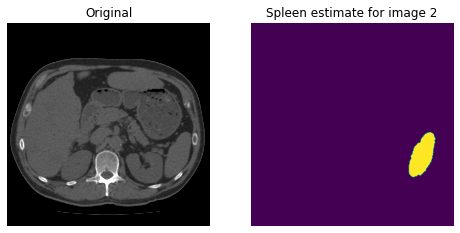

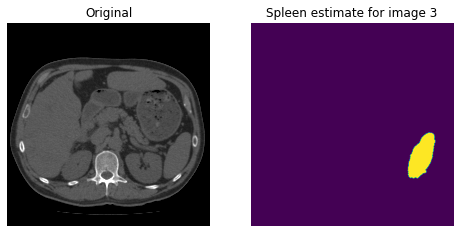

In [76]:
def load_dcm(path):
    ct = dicom.read_file(path)
    img = ct.pixel_array
    return img

for i in range(1, 4):
    path = f"data/Validation{i}.dcm"
    img = load_dcm(path)
    spleen_estimate = spleen_finder(img)
    show_comparison(img, spleen_estimate, f"Spleen estimate for image {i}")

In [78]:
def dice_score(img,gt):
    dice_score = 1 - distance.dice(img.ravel(), gt.ravel())
    return dice_score

for i in range(1, 4):
    path = f"data/Validation{i}.dcm"
    img = load_dcm(path)
    spleen_estimate = spleen_finder(img)
    spleen_gt = load_mask(f"data/Validation{i}_spleen.png")
    dice = dice_score(spleen_estimate, spleen_gt)
    print(f"Dice score for validation image {i}: {dice:.3f}")

Dice score for validation image 1: 0.956
Dice score for validation image 2: 0.962
Dice score for validation image 3: 0.972


In [79]:
for i in range(1, 4):
    path = f"data/Test{i}.dcm"
    img = load_dcm(path)
    spleen_estimate = spleen_finder(img)
    spleen_gt = load_mask(f"data/Test{i}_spleen.png")
    dice = dice_score(spleen_estimate, spleen_gt)
    print(f"Dice score for validation image {i}: {dice:.3f}")

Dice score for validation image 1: 0.650
Dice score for validation image 2: 0.952
Dice score for validation image 3: 0.967
